# Implement Masking and Test Issue 517

Testing for weighted masks and fix [#517](https://github.com/materialsinnovation/pymks/issues/517).

In [1]:
import dask.array as da
import numpy as np
from pymks.fmks import correlations
from pymks import plot_microstructures

In [2]:
A = da.from_array(np.array([
    [
        [1, 0, 0],
        [0, 1, 1],
        [1, 1, 0]
    ],
    [
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1]
    ]
]))
mask = np.ones((2,3,3))
mask[:,2,1:] = 0
mask = da.from_array(mask)

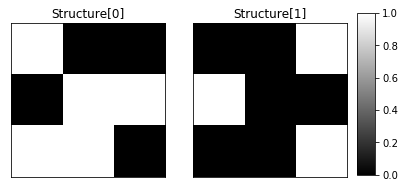

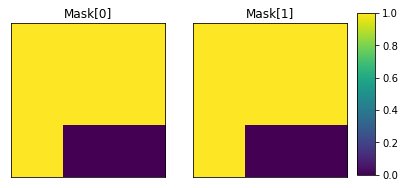

In [3]:
plot_microstructures(A[0], A[1],
                     titles=['Structure[0]', 'Structure[1]'],
                     cmap='gray', figsize_weight=2.5)
plot_microstructures(mask[0], mask[1],
                     titles=['Mask[0]', 'Mask[1]'],
                     cmap='viridis', figsize_weight=2.5)


## Check that periodic still works

The normalization occurs in the two_point_stats function and the auto-correlation/cross-correlation occur in the cross_correlation function. Checking that the normalization is properly calculated.

First is the auto-correlation. Second is the cross-correlation.

In [4]:
correct = (correlations.cross_correlation(A, A).compute() / 9).round(3).astype(np.float64)
tested = correlations.two_point_stats(A, A).compute().round(3).astype(np.float64)
assert (correct == tested).all()

In [5]:
correct = (correlations.cross_correlation(A, 1-A).compute() / 9).round(3).astype(np.float64)
tested = correlations.two_point_stats(A, 1-A).compute().round(3).astype(np.float64)
assert (correct == tested).all()

## Check that masked periodic works

Two point statistics are part correlation and part normalization. The correlation sums up the number of possible 2-point states. In masked periodic, we assume that vectors going across the boundary of the structure come back on the other side. However, a vector landing in the masked area is discarded (ie not included in the correlation sum).

Below, are the hand computed correlation and normalization. The correct 2point stats are the correlation divided by the normalization. First, is the auto-correlation and second is the cross-correlation.

In [6]:
correct_periodic_mask_auto = np.array([
    [
        [2,1,2],
        [1,4,1],
        [2,1,2]
    ],
    [
        [1,0,0],
        [0,2,0],
        [0,0,1]
    ]
])

correct_periodic_mask_cross = np.array([
    [
        [1,3,1],
        [2,0,2],
        [1,1,1]
    ],
    [
        [0,1,2],
        [2,0,2],
        [1,2,0]
    ]
])

norm_periodic_mask = np.array([
    [5,5,5],
    [6,7,6],
    [5,5,5]
])

# Auto-Correlation
correct = (correct_periodic_mask_auto / norm_periodic_mask).round(3).astype(np.float64)
tested = correlations.two_point_stats(A, A, mask=mask, periodic_boundary=True).compute().round(3).astype(np.float64)

assert (correct == tested).all()

# Cross-Correlation
correct = (correct_periodic_mask_cross / norm_periodic_mask).round(3).astype(np.float64)
tested = correlations.two_point_stats(A, 1-A, mask=mask, periodic_boundary=True).compute().round(3).astype(np.float64)

assert (correct == tested).all()

## Test that non-periodic works

Two point statistics are part correlation and part normalization. The correlation sums up the number of possible 2-point states. In non-periodic, we assume that a vector used to count up 2 point states can only connect two states in the structure. A vector going outside of the bounds of the structure is not counted.

Below, are the hand computed correlation and normalization. The correct 2point stats are the correlation divided by the normalization. First, is the auto-correlation and second is the cross-correlation.

In [7]:
correct_nonperiodic_auto = np.array([
    [
        [1,1,2],
        [2,5,2],
        [2,1,1]
    ],
    [
        [0,0,0],
        [0,3,0],
        [0,0,0]
    ]
])

correct_nonperiodic_cross = np.array([
    [
        [2,3,1],
        [1,0,2],
        [0,2,1]
    ],
    [
        [1,2,1],
        [2,0,1],
        [1,2,1]
    ]
])

norm_nonperiodic = np.array([
    [4,6,4],
    [6,9,6],
    [4,6,4]
])

# Auto-Correlation
correct = (correct_nonperiodic_auto / norm_nonperiodic).round(3).astype(np.float64)
tested = correlations.two_point_stats(A, A, periodic_boundary=False).compute().round(3).astype(np.float64)

assert (correct == tested).all()

# Cross-Correlation
correct = (correct_nonperiodic_cross / norm_nonperiodic).round(3).astype(np.float64)
tested = correlations.two_point_stats(A, 1-A, periodic_boundary=False).compute().round(3).astype(np.float64)

assert (correct == tested).all()

## Check that non-periodic masking works

In non-periodic masking, vectors that go across the boundary or land in a mask are not included in the sum.

In [8]:
correct_nonperiodic_mask_auto = np.array([
    [
        [1,0,1],
        [1,4,1],
        [1,0,1]
    ],
    [
        [0,0,0],
        [0,2,0],
        [0,0,0]
    ]
])

correct_nonperiodic_mask_cross = np.array([
    [
        [1,3,1],
        [1,0,1],
        [0,1,0]
    ],
    [
        [0,1,1],
        [1,0,1],
        [1,2,0]
    ]
])

norm_nonperiodic_mask = np.array([
    [2,4,3],
    [4,7,4],
    [3,4,2]
])

# Auto-Correlation
correct = (correct_nonperiodic_mask_auto / norm_nonperiodic_mask).round(3).astype(np.float64)
tested = correlations.two_point_stats(A, A, mask=mask, periodic_boundary=False).compute().round(3).astype(np.float64)
assert (correct == tested).all()

# Cross-Correlation
correct = (correct_nonperiodic_mask_cross / norm_nonperiodic_mask).round(3).astype(np.float64)
tested = correlations.two_point_stats(A, 1-A, mask=mask, periodic_boundary=False).compute().round(3).astype(np.float64)
assert (correct == tested).all()

## Check that different sized dask arrays are valid masks.

We want to be able to specify the same mask for each sample. We also want to be able to specify a different mask for each sample. This validates that both are possible.

In [9]:
A = da.random.random([1000,3,3])

mask_same4all = da.random.randint(0,2,[3,3])
mask_same4some = da.random.randint(0,2,[100,3,3])
mask_diff4all = da.random.randint(0,2,[1000,3,3])

correlations.two_point_stats(A, A, mask=mask_same4all)
# The following check fails. Therefore, the current implementation
# only works for one mask for all or different mask for all, which
# is feature rich enough for me.
# correlations.two_point_stats(A, A, mask=mask_same4some)
correlations.two_point_stats(A, A, mask=mask_diff4all)

dask.array<truediv, shape=(1000, 3, 3), dtype=float64, chunksize=(1000, 3, 3), chunktype=numpy.ndarray>

## Some check that boolean and integers are valid masks

A mask could be true and false specifying where there is a microstructure. However, it could also be any value in the range $[0,1]$ which specifies the probability a value is correctly assigned. The mask right now only implements confidence in a single phase, although idealy it should represent the confidence in all phases. However, for the use cases where there are 2 phases, a mask with a probability for one phase also completely describes the confidence in the other phase. Therefore, this implementation is complete for 2 phases.

In [10]:
mask_int = da.random.randint(0,2,[1000,3,3])
mask_bool = mask_int.copy().astype(bool)

print(mask_int.dtype, mask_bool.dtype)

correlations.two_point_stats(A, A, mask=mask_int)
correlations.two_point_stats(A, A, mask=mask_bool)

int64 bool


dask.array<truediv, shape=(1000, 3, 3), dtype=float64, chunksize=(1000, 3, 3), chunktype=numpy.ndarray>